In [53]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [54]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def display_rgb(
    img: Union[Dict, None], 
    alpha=1., 
    figsize=(10, 10)
    ) -> None:
    rgb = np.stack(
        [img['B4'], img['B3'], img['B2']],
        axis=-1
    )
    rgb = rgb/rgb.max() * alpha
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    
def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

def convert_to_hsv(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV_FULL)
    return hsv

In [55]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/'
band_labels = ["B4", "B3", "B2"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20201010T165129_20201010T165745_T15TXG_10Oct2020_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20201010T165129_20201010T165745_T15TXG_10Oct2020_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20201010T165129_20201010T165745_T15TXG_10Oct2020_B2.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20200710T165901_20200710T170849_T15TXG_10Jul2020_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20200710T165901_20200710T170849_T15TXG_10Jul2020_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20200710T165901_20200710T170849_T15TXG_10Jul2020_B2.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-

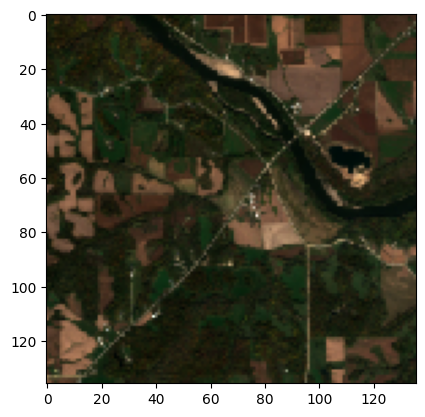

In [56]:
test_image = convert_to_eight_bits(images[img_keys[0]])
plt.imshow(test_image)

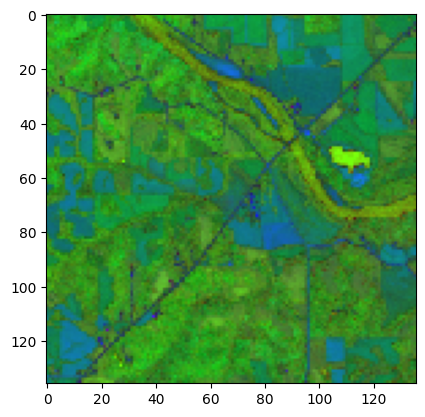

In [57]:
hsv_test = convert_to_hsv(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.imshow(hsv_test)

In [65]:
g_filt = cv2.cvtColor(hsv_test, cv2.COLOR_BGR2GRAY)
hsv_filt = cv2.cvtColor(test_image, cv2.COLOR_BGR2HSV)

gaussian_filter = cv2.GaussianBlur(hsv_filt, (5,5), 0)
gauss_canny = cv2.Canny(gaussian_filter, 100, 100)

grey_canny = cv2.Canny(g_filt, 100,100)

orig = test_image.copy()

(contours, _) = cv2.findContours(gauss_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(orig,contours,-1,(0,0,255), 2)

array([[[ 31,  29,  15],
        [ 37,  36,  15],
        [  0,   0, 255],
        ...,
        [ 63,  41,  28],
        [ 66,  42,  30],
        [ 67,  44,  31]],

       [[ 32,  35,  15],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 37,  32,  20],
        [ 53,  37,  26],
        [ 62,  42,  30]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [ 64,  44,  31]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [ 19,  23,  14],
        [ 26,  27,  15],
        [ 25,  35,  19]],

       [[121,  94,  68],
        [ 85,  72,  42],
        [ 74,  67,  47],
        ...,
        [ 22,  28,  16],
        [ 25,  28,  14],
        [ 31,  36,  17]],

       [[129,  88,  63],
        [116,  82,  57],
        [ 77,  54,  36],
        ...,
        [ 16,  27,  13],
        [ 29,  38,  17],
        [ 29,  32,  18]]

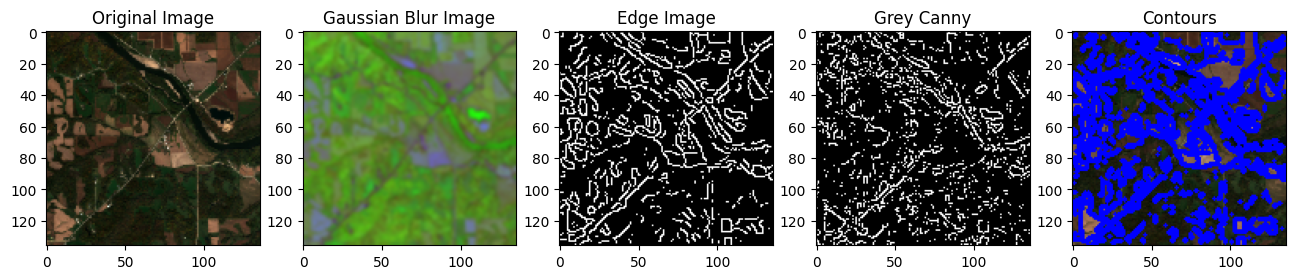

In [66]:
fig, axes = plt.subplots(1,5, figsize=(16, 10), facecolor='w', edgecolor='k')
axes = axes.ravel()

axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original Image'), #axes[0].xticks([]), axes[0].yticks([])
axes[1].imshow(gaussian_filter, cmap='gray')
axes[1].set_title('Gaussian Blur Image'), #axes[1].xticks([]), axes[1].yticks([])
axes[2].imshow(gauss_canny, cmap='gray')
axes[2].set_title("Edge Image"), #axes[2].xticks([]), axes[2].yticks([])
axes[3].imshow(grey_canny, cmap='gray')
axes[3].set_title("Grey Canny"), #axes[2].xticks([]), axes[2].yticks([])
axes[4].imshow(orig, cmap='gray')
axes[4].set_title("Contours"), #axes[2].xticks([]), axes[2].yticks([])
plt.show()

In [64]:
print(" {} objetos encontrados".format(len(contours)))

 269 objetos encontrados


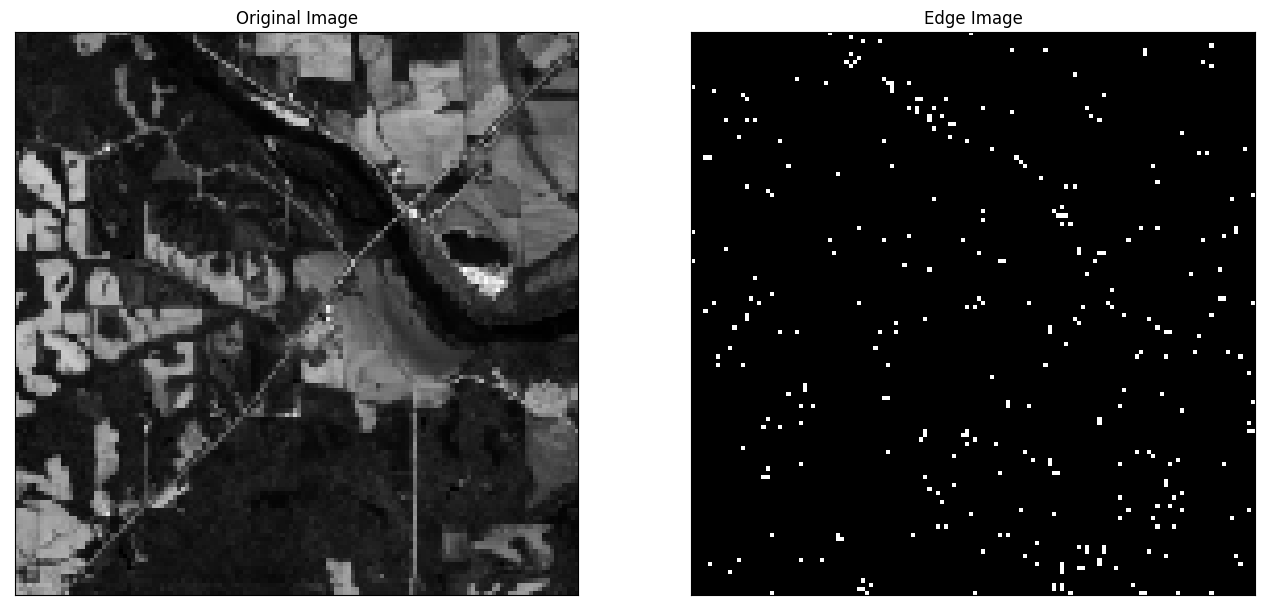

In [63]:
img = cv2.imread('/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData/S-HARMONIZED_20200508T164901_20200508T165551_T15TXG_08May2020_B4.tif', flags=(cv2.IMREAD_ANYDEPTH))
img_canny = np.uint8(img)
edges = cv2.Canny(img_canny,1000,1000)

plt.figure(figsize=(16, 10))

plt.subplot(121),plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()